<a href="https://colab.research.google.com/github/darren-source/SupervisedLLMText/blob/main/Copy119A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning LLM Pipeline Using TensorFlow and BERT
### Flow-Chart

## Start
Set up environment and importing libraries.

## Load Data from Kaggle
Kaggle API used to download datasets directly.

## Preprocess Data
- **Categorize Data**(Healthy, non-healthy living)
- **Auto-Tokenize Combined Text**
- **Encode Labels**

## Split Data
Use `train_test_split` to divide the data into training and test sets.

## Prepare TensorFlow Dataset
Convert the data into a TensorFlow Dataset. Convert tokenized text into binary labels.

## Load Pretrained Model (BERT)
Load small version pretrained BERT model from the Hugging Face `transformers` library.

## Compile Model
- **Optimizer**: ADAM
- **Loss Function**: Binary Cross-Entropy

## Train Model
Train the model using the prepared datasets.

## Evaluate Model
Evaluate the trained model on the test set to understand its performance. Use Accuracy, Precision, and Recall to measure its effectiveness.

In [1]:
# Import files from Google Colab
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darrencampbell","key":"0e938d7dfab152dd343bb94656320b7a"}'}

In [2]:
# Install the Kaggle API library to enable Kaggle dataset downloads
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the 'news-category-dataset' from Kaggle
!kaggle datasets download -d rmisra/news-category-dataset

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 90% 24.0M/26.5M [00:02<00:00, 17.8MB/s]
100% 26.5M/26.5M [00:02<00:00, 11.7MB/s]


In [4]:
# Extract the contents of the 'news-category-dataset.zip' file
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [5]:
# Load data from a JSON file into a pandas DataFrame.
import pandas as pd
data = pd.read_json("News_Category_Dataset_v3.json", lines=True)

data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
# Create a sample of the dataset due to GPU time restraints
sampled_data = data.sample(frac=0.25, random_state=42)

In [7]:
# Display the unique values in the 'category' column
sampled_data['category'].unique()


array(['IMPACT', 'BUSINESS', 'POLITICS', 'GREEN', 'SCIENCE', 'PARENTING',
       'WELLNESS', 'STYLE & BEAUTY', 'QUEER VOICES', 'EDUCATION',
       'BLACK VOICES', 'TRAVEL', 'DIVORCE', 'HEALTHY LIVING', 'TASTE',
       'THE WORLDPOST', 'COMEDY', 'WORLDPOST', 'ENTERTAINMENT', 'STYLE',
       'FOOD & DRINK', 'HOME & LIVING', 'GOOD NEWS', 'MEDIA', 'SPORTS',
       'CRIME', 'MONEY', 'WORLD NEWS', 'COLLEGE', 'RELIGION', 'WOMEN',
       'PARENTS', 'ARTS', 'ARTS & CULTURE', 'ENVIRONMENT', 'WEDDINGS',
       'U.S. NEWS', 'TECH', 'LATINO VOICES', 'WEIRD NEWS',
       'CULTURE & ARTS', 'FIFTY'], dtype=object)

In [8]:
# Create a new column 'health_related'.
# Assign 1 if the category is in the health-related list, otherwise assign 0.

health_related_categories = ['HEALTHY LIVING']

sampled_data['health_related'] = sampled_data['category'].apply(lambda x: 1 if x in health_related_categories else 0)

In [9]:
# Count the occurrences of each unique value in the 'health_related' column.
counts = sampled_data['health_related'].value_counts()

print(counts)

health_related
0    50739
1     1643
Name: count, dtype: int64


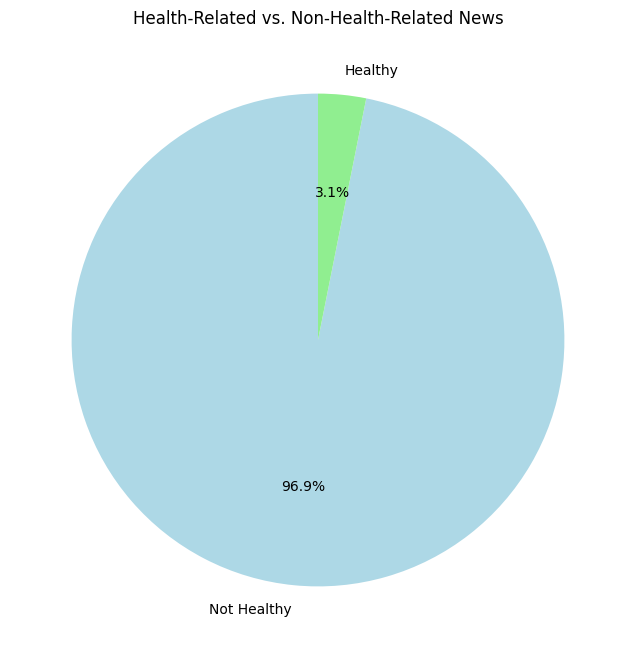

In [10]:
# Create the pie chart for labels "Healthy" and "Not Healthy"

import matplotlib.pyplot as plt

labels = ['Not Healthy', 'Healthy']
sizes = [50739, 1643]
colors = ['lightblue', 'lightgreen']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Health-Related vs. Non-Health-Related News')
plt.show()

In [11]:
# Combine the 'headline' and 'short_description' columns into a single column called 'text'.
sampled_data['text'] = sampled_data['headline'] + " " + sampled_data['short_description']

In [12]:
# Select only the 'health_related' and 'text' columns from the DataFrame for the model
sampled_data = sampled_data.loc[:, ['health_related', 'text']]

In [13]:
# sampled data first 5 rows
sampled_data.head()


,health_related,text
128310,0,What If We Were All Family Generation Changers...
139983,0,Firestorm At AOL Over Employee Benefit Cuts It...
42339,0,Dakota Access Protesters Arrested As Deadline ...
131494,0,One Glimpse Of These Baby Kit Foxes And You'll...
163649,0,"Mens' Sweat Pheromone, Androstadienone, Influe..."


In [15]:
# Load a pre-trained DistilBERT tokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode text
def encode_texts(tokenizer, texts, max_len=128):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors="tf")




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [26]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(sampled_data, test_size=0.2, random_state=42)  # Split 20% for validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [30]:
# Data from the DataFrames for training, validation, and testing
train_encodings = encode_texts(tokenizer, train_df['text'].tolist())
val_encodings = encode_texts(tokenizer, val_df['text'].tolist())
test_encodings = encode_texts(tokenizer, test_df['text'].tolist())

# Convert the integer labels to binary class matrix for use with categorical crossentropy
from tensorflow.keras.utils import to_categorical
test_labels = to_categorical(test_df['health_related'].values)
train_labels = to_categorical(train_df['health_related'].values)
val_labels = to_categorical(val_df['health_related'].values)

# Create a Tensorflow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(32)

In [31]:
# Convert to tf.data.Dataset
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(32)

In [32]:
from transformers import TFDistilBertForSequenceClassification, AdamWeightDecay

# Initialize the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)  # Assuming binary classification


optimizer = AdamWeightDecay(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
1310/1310 [==============================] - 202s 148ms/step - loss: 0.1080 - accuracy: 0.9681 - val_loss: 0.0894 - val_accuracy: 0.9656
Epoch 2/5
1310/1310 [==============================] - 192s 147ms/step - loss: 0.0681 - accuracy: 0.9748 - val_loss: 0.1219 - val_accuracy: 0.9677
Epoch 3/5
1310/1310 [==============================] - 192s 147ms/step - loss: 0.0386 - accuracy: 0.9862 - val_loss: 0.1462 - val_accuracy: 0.9626
Epoch 4/5
1310/1310 [==============================] - 192s 147ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.2147 - val_accuracy: 0.9590
Epoch 5/5
1310/1310 [==============================] - 192s 147ms/step - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.2109 - val_accuracy: 0.9695


In [33]:
# Display the architecture of the model
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# Predict labels for the test dataset
y_pred = model.predict(test_dataset)
y_pred_class = (y_pred.logits > 0.5).astype(int)

164/164 [==============================] - 7s 44ms/step


In [40]:
y_pred = y_pred_class.argmax(axis=1)

from sklearn.metrics import classification_report

report = classification_report(test_labels.argmax(axis=1), y_pred, output_dict=True)
# Print a formatted classification report
print(classification_report(test_labels.argmax(axis=1), y_pred))

{'0': {'precision': 0.9730620155038759, 'recall': 0.9907261247040252, 'f1-score': 0.9818146265154478, 'support': 5068.0}, '1': {'precision': 0.4050632911392405, 'recall': 0.1871345029239766, 'f1-score': 0.256, 'support': 171.0}, 'accuracy': 0.9644970414201184, 'macro avg': {'precision': 0.6890626533215582, 'recall': 0.588930313814001, 'f1-score': 0.6189073132577239, 'support': 5239.0}, 'weighted avg': {'precision': 0.954522641221312, 'recall': 0.9644970414201184, 'f1-score': 0.9581241701050371, 'support': 5239.0}}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5068
           1       0.41      0.19      0.26       171

    accuracy                           0.96      5239
   macro avg       0.69      0.59      0.62      5239
weighted avg       0.95      0.96      0.96      5239



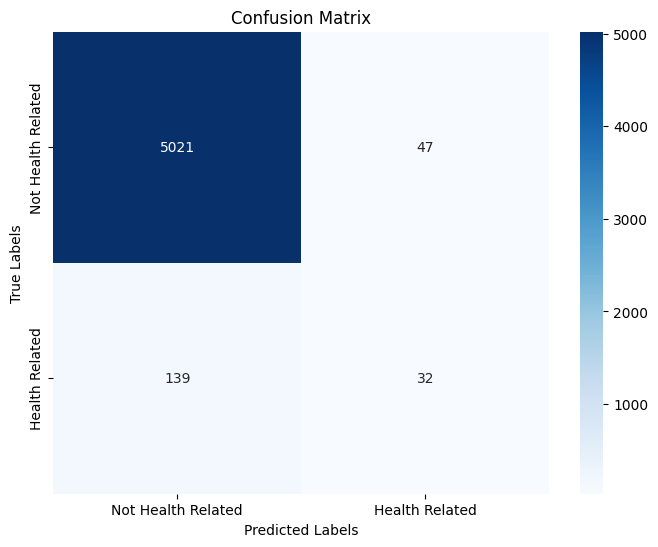

In [42]:
# Compute the confusion matrix comparing true labels with predicted labels.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_labels_single_class = test_labels.argmax(axis=1)

cm = confusion_matrix(test_labels_single_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Health Related', 'Health Related'], yticklabels=['Not Health Related', 'Health Related'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()